Arboles de decision 

Juan David Meza
grupo 1704

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
import seaborn as sns
import graphviz
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

In [8]:
#Cargar los datos
df = pd.read_csv('winequality-red.csv')
#visulizacion de datos
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

In [10]:
#Preprocesamiento de datos
X = df.drop('quality', axis=1)
y = df['quality']

In [12]:
# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
#Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [16]:
#Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [18]:
#Crear el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

In [20]:
#Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [22]:
#Realizar la búsqueda de cuadrícula
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1_weighted')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted')

In [24]:
#Mejor modelo
best_rf_model = grid_search_rf.best_estimator_
print("Mejores hiperparámetros para Random Forest:", grid_search_rf.best_params_)

Mejores hiperparámetros para Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [26]:
#Realizar predicciones
y_pred_rf = best_rf_model.predict(X_test)

In [28]:
#Evaluar el modelo en el conjunto de prueba
print("Informe de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

Informe de clasificación para Random Forest:
              precision    recall  f1-score   support

           3       0.99      1.00      0.99       132
           4       0.87      0.97      0.92       131
           5       0.72      0.75      0.73       150
           6       0.74      0.56      0.64       155
           7       0.85      0.95      0.90       116
           8       0.98      1.00      0.99       134

    accuracy                           0.86       818
   macro avg       0.86      0.87      0.86       818
weighted avg       0.85      0.86      0.85       818



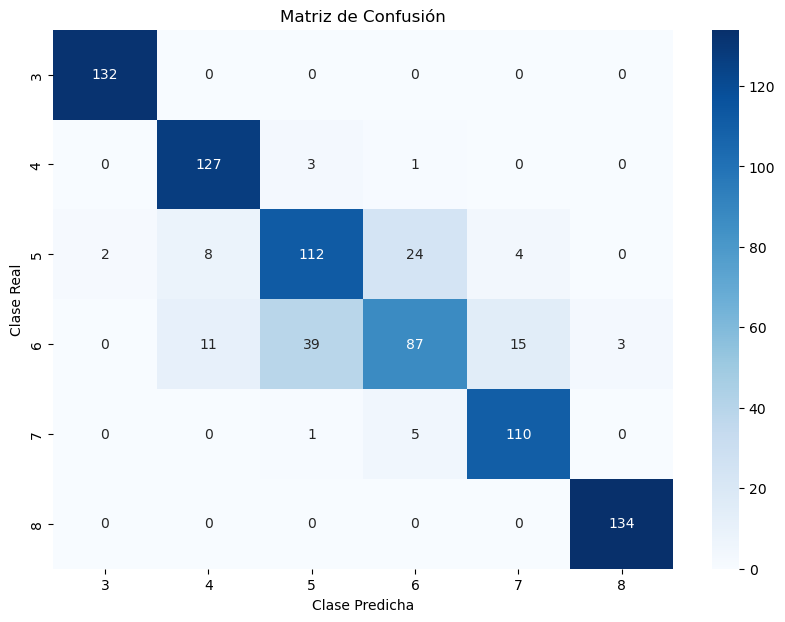

In [30]:
#Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.title('Matriz de Confusión')
plt.show()

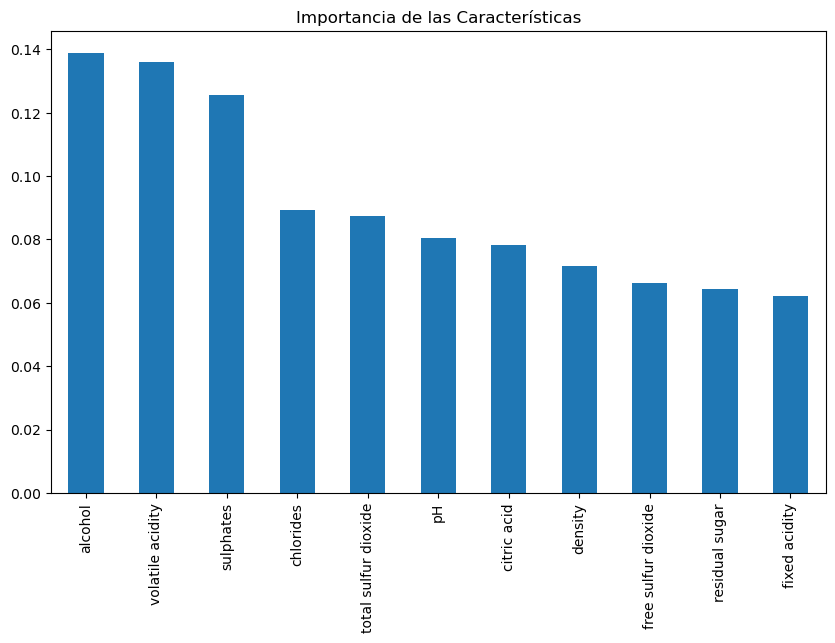

In [32]:
#Importancia de las características
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Importancia de las Características")
plt.show()

In [34]:
# Crear el modelo de árbol de decisiones
tree_model = DecisionTreeClassifier(random_state=42)

# Ajustar el modelo
tree_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_tree = tree_model.predict(X_test)

# Evaluar el rendimiento del árbol de decisiones
print("Informe de clasificación para Árbol de Decisión:")
print(classification_report(y_test, y_pred_tree))

Informe de clasificación para Árbol de Decisión:
              precision    recall  f1-score   support

           3       0.99      1.00      0.99       132
           4       0.78      0.89      0.83       131
           5       0.68      0.64      0.66       150
           6       0.60      0.54      0.57       155
           7       0.76      0.79      0.78       116
           8       0.95      0.93      0.94       134

    accuracy                           0.79       818
   macro avg       0.79      0.80      0.80       818
weighted avg       0.79      0.79      0.79       818



In [58]:
# Exportar el árbol en formato Graphviz
dot_data = export_graphviz(tree_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['3', '4', '5', '6', '7', '8'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Usar Graphviz para renderizar el árbol
graph = graphviz.Source(dot_data)
graph.render("arbol_decision_vino", format="png") # Genera una imagen PNG del árbol
graph.view()  # Abre el archivo de imagen

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.746758 to fit


'arbol_decision_vino.pdf'

Análisis del Informe de Clasificación y Datos Químicos del Vino
A partir del informe de clasificación del modelo de Árbol de Decisión y las estadísticas descriptivas de los componentes químicos del vino, se pueden extraer varias conclusiones en términos de la precisión del modelo y cómo los atributos químicos influyen en la calidad del vino.

Precisión Global: El modelo alcanzó una precisión del 79%, lo que sugiere que el Árbol de Decisión es relativamente efectivo al predecir la calidad de los vinos en esta base de datos. Sin embargo, no todos los niveles de calidad se predicen de manera uniforme.

Análisis por Categorías de Calidad:
Calidad 3: Alta precisión (0.99) y recall (1.00), lo que significa que el modelo predice de manera efectiva vinos de calidad baja, aunque son poco comunes en el dataset (sólo 2 vinos de esta calidad).

Calidad 4: Una precisión aceptable (0.78) y un recall relativamente alto (0.89), lo que sugiere que el modelo también maneja bien los vinos de calidad baja/moderada.

Calidad 5: El modelo tiene una precisión media (0.68) y un recall moderado (0.64). esta  categoría tiene el mayor número de ejemplos, lo que explica por qué es más difícil para el modelo capturar todos los matices.

Calidad 6 y 7: Los vinos de calidad 6 y 7 muestran una precisión algo más baja. Para la calidad 6, la precisión es del 0.60 y el recall del 0.54, lo que indica cierta dificultad del modelo para distinguir adecuadamente los vinos de calidad superior

Calidad 8: Aunque se predice con alta precisión (0.95), el número de muestras en esta categoría es menor, por lo que las predicciones podrían no ser tan robustas.
